In [1]:
# Copyright (c) 2019 ETH Zurich, Lukas Cavigelli, Georg Rutishauser, Luca Benini

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc('axes', axisbelow=True)

from dataCollect import getModel, getFMs
from analysisTools import Analyzer

In [2]:
#instantiate dataset loader and pre-trained model
training = True

#only possible for self-trained networks: 
modelName, epochs = 'alexnet-cust', list(range(1,55, 1))
# modelName, epochs = 'mobilenetV2-cust', list(range(1,20, 2)) + list(range(20,201, 20))

In [3]:
# gather sparsity data by epoch
analyzer = Analyzer(quantMethod='fixed16', compressor=None)
# sparsitiesGradByEpoch = []
sparsitiesOutpByEpoch = []
for epoch in epochs:
    print('epoch: %d' % epoch)
    
    model, loss_func, path = getModel(modelName, epoch=epoch, returnPath=True)
    outputsReLU, _, _, _ = getFMs(
        model, loss_func, training=training, numBatches=1, batchSize=10)
    
    sparsitiesOutp = [analyzer.getSparsity(outp) for outp in outputsReLU]
    sparsitiesOutpByEpoch.append(sparsitiesOutp)
#     sparsitiesGrad = [analyzer.getSparsity(outp) for outp in gradsReLU]
#     sparsitiesGradByEpoch.append(sparsitiesGrad)

layerIdxs = [i+1 for i in range(len(outputsReLU))]

epoch: 1
epoch: 11
epoch: 21
epoch: 31
epoch: 41
epoch: 51


In [4]:
#get validation accuracy trace
from dataCollect import getTensorBoardData
# path = './quantLab/ImageNet/log/exp00'
steps, trainAccByEpoch = getTensorBoardData(path + '/stats', 'train_metric')
steps, trainLossByEpoch = getTensorBoardData(path + '/stats', 'train_loss')
steps, validAccByEpoch = getTensorBoardData(path + '/stats', 'valid_metric')
steps, validLossByEpoch = getTensorBoardData(path + '/stats', 'valid_loss')

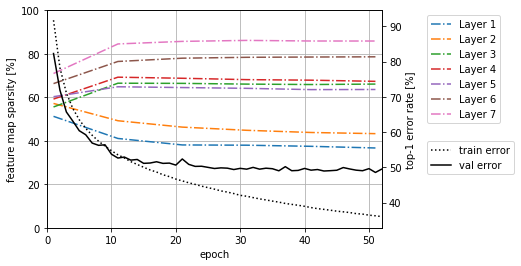

In [5]:
#plot sparsity by epcoh
handles = plt.plot(epochs, [[a*100 for a in b] for b in sparsitiesOutpByEpoch], '-.')
layerNames = ['Layer %d' % lid for lid in layerIdxs]
if len(layerNames) >= 8:
    legendIndexes = [0,1,2,3,4,5,6,len(layerNames)-1]
    layerNames[6] = '    ...  '
else:
    legendIndexes = list(range(len(layerNames)))
    
# plt.legend(['Layer %d' % lid for lid in layerIdxs], ncol=2)
plt.legend(labels=[layerNames[idx] for idx in legendIndexes], 
           handles=[handles[idx] for idx in legendIndexes], 
           bbox_to_anchor=(1.12, 1))
plt.ylabel('feature map sparsity [%]')
plt.xlabel('epoch')
plt.ylim(bottom=0, top=100)
plt.xlim(left=0, right=epochs[-1]+1)
plt.grid(True)
#overlay validation accuracy
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(steps, trainAccByEpoch[:len(steps)], linestyle='dotted', color='k')
ax2.plot(steps, validAccByEpoch, linestyle='solid', color='k')
ax2.set_ylabel('top-1 error rate [%]')
plt.legend(['train error', 'val error'], bbox_to_anchor=(1.41, 0.42))
#save figure
plt.savefig('figs/sparsityByEpoch-%s.pdf' % modelName, bbox_inches='tight', pad_inches=0.0)

In [6]:
# print(sparsitiesGrad)
# print(sparsitiesOutp)
# print(gradsReLU[0][1:5,1:9])
# print(outputsReLU[0][1:5,1:9])

NOTES: 
- sparsity of gradients and activations is obviously the same
- the layers of the gradient output should be flipped (as the hooks are triggered back-to-front)